# Predicting the energy of isomers

In this lecture, a ML regression model will be trained to predict the energies of molecular isomers.

## Step 1: Create dataset
Read in the molecule structures and inspect the data.

In [4]:
import matplotlib.pyplot as plt
from pymatgen.core.structure import Molecule
import pickle
import pandas as pd
import numpy as np
from openbabel import pybel

In [ ]:
def xyz_to_smiles(fname: str) -> str:
    
    mol = next(pybel.readfile("xyz", fname))

    smi = mol.write(format="smi")

    return smi.split()[0].strip()

In [44]:
# Read in all the structures as the pymatgen Molecule object, save them as a pkl file
smiles = []
f = open('isomers.txt', 'r')
lines = f.readlines()
for i in range(1, len(lines)+1):
    if i % 21 == 0:
        example_xyz = open('single.xyz', 'w')
        for line in lines[i-21:i]:
            example_xyz.write(line)
        smi = xyz_to_smiles("single.xyz")
        smiles.append(smi)
with open('all_smi.pkl','wb') as f:
    pickle.dump(smiles, f)

In [23]:
# Read in the energies and combine them the structures, save them as a csv data file
f = open('energies.txt', 'r')
lines = f.readlines()
energies = []
for energy in lines[1:]:
    energies.append(float(energy.strip('\n').split(' ')[1]))
dataset = pd.DataFrame({'structures': smiles, 'energies': energies})
dataset.to_csv('dataset.csv')

In [76]:
middle = dataset['energies'].median()

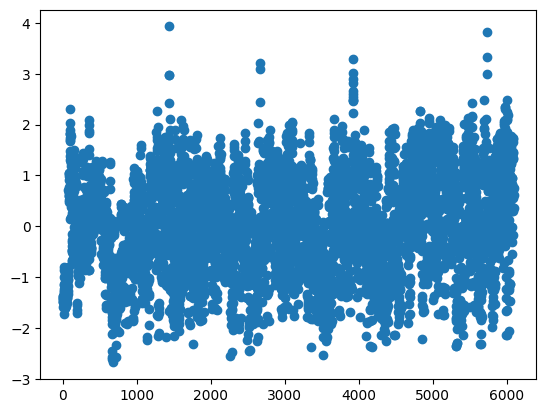

In [78]:
# Inspect the energies distribution, set the median of all energies as the center
x = np.arange(0, 6095)
plt.scatter(x, dataset['energies']-middle)

# Step 2: Featurization
Invariant features or equivariant features

In [ ]:
import deepchem as dc

In [10]:
dataset = pd.read_csv('dataset.csv')

In [11]:
featurizer = dc.feat.CircularFingerprint(size=1024)
ecfp = featurizer.featurize(dataset['structures'])
dataset2 = dc.data.NumpyDataset(X=ecfp, y=np.array(dataset['energies']))
len(dataset2)

6095

## Step 3: Machine learning models

Splitting the data

In [14]:
splitter = dc.splits.RandomSplitter()
 # split 5 datapoints in the ratio of train:valid:test = 3:1:1
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset=dataset2, frac_train=0.6, frac_valid=0.2, frac_test=0.2)
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

3657
1219
1219


In [15]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
model = dc.models.SklearnModel(model=rf)
# model training
model.fit(train_dataset)
valid_preds = model.predict(valid_dataset)
print(valid_preds.shape)
test_preds = model.predict(test_dataset)
print(test_preds.shape)

(1219,)
(1219,)


## Step 4: Model evaluation

In [17]:
# initialze the metric
metric = dc.metrics.Metric(dc.metrics.mae_score)
# evaluate the model
train_score = model.evaluate(train_dataset, [metric])
valid_score = model.evaluate(valid_dataset, [metric])
test_score = model.evaluate(test_dataset, [metric])
print(train_score)
print(valid_score)  
print(test_score)

{'mae_score': 0.1863286607032335}
{'mae_score': 0.4935808266292595}
{'mae_score': 0.49180908072345275}


## Homework
1. Explore different machine learning models, svm, rf, xgb to find the best model.
2. Think what is the limitations in featurisation and model training. 